In [6]:
# ============================================================
#  SECTION 0: IMPORTS & DATA LOADING
# ============================================================

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Load dataset
df = pd.read_csv("C:/Users/hp/OneDrive/Desktop/Customer Churn Prediction/data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
# ============================================================
#  SECTION 1: BASIC DATA CLEANING
#  WHY: Convert types, handle missing & numeric conversions
# ============================================================

# Convert TotalCharges to numeric (contains spaces for new customers)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Remove customerID - not predictive
df = df.drop(columns=["customerID"])

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


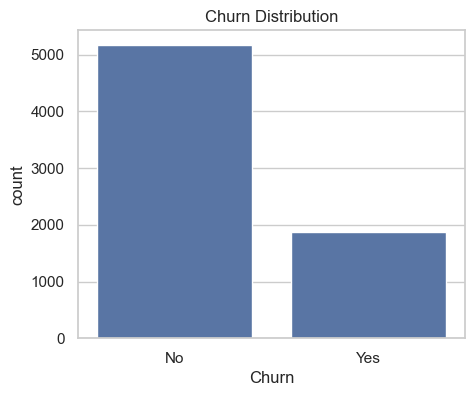

In [8]:
# ============================================================
# CHURN DISTRIBUTION
# WHY: Check class imbalance
# ============================================================

plt.figure(figsize=(5,4))
sns.countplot(x=df['Churn'])
plt.title("Churn Distribution")
plt.show()



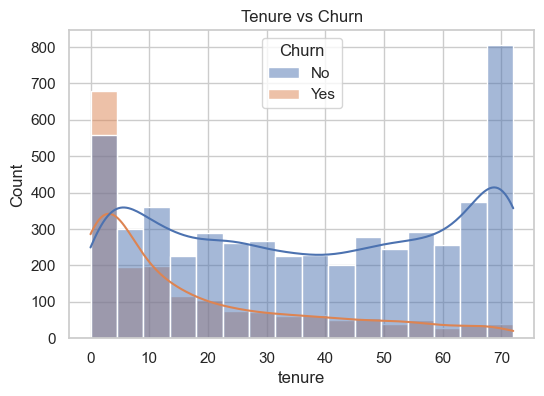

In [9]:
# ============================================================
# TENURE vs CHURN
# WHY: Check relationship between service duration and churn
# ============================================================

plt.figure(figsize=(6,4))
sns.histplot(data=df, x='tenure', hue='Churn', kde=True)
plt.title("Tenure vs Churn")
plt.show()


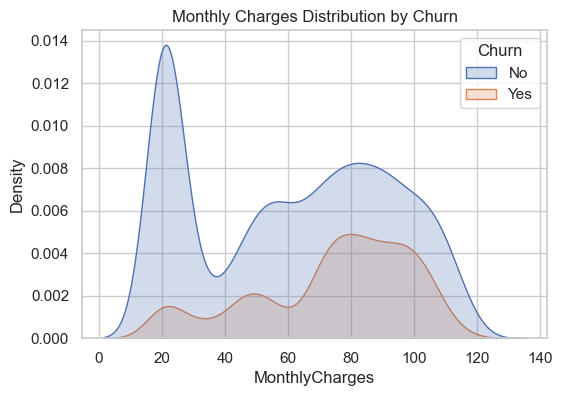

In [10]:
# ============================================================
# MONTHLY CHARGES
# WHY: Customers paying higher fees may churn more
# ============================================================

plt.figure(figsize=(6,4))
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True)
plt.title("Monthly Charges Distribution by Churn")
plt.show()


In [ ]:
# ============================================================
# BASELINE PHASE (NO FEATURE ENGINEERING)
# ============================================================

df_baseline = df.copy()

df_baseline['Churn'] = df_baseline['Churn'].map({'Yes':1,'No':0})

df_baseline = pd.get_dummies(df_baseline)

X = df_baseline.drop('Churn', axis=1)
y = df_baseline['Churn']

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_b, y_train_b)

y_pred_b = log_reg.predict(X_test_b)

baseline_results = {
    "Accuracy": accuracy_score(y_test_b, y_pred_b),
    "Precision": precision_score(y_test_b, y_pred_b),
    "Recall": recall_score(y_test_b, y_pred_b),
    "F1": f1_score(y_test_b, y_pred_b)
}

baseline_results


c:\Users\hp\OneDrive\Desktop\Customer Churn Prediction\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Accuracy': 0.8232789212207239,
 'Precision': 0.6890243902439024,
 'Recall': 0.6058981233243967,
 'F1': 0.644793152639087}

In [12]:
# ============================================================
# FEATURE ENGINEERING PIPELINE
# ============================================================

df_pro = df.copy()

df_pro['Churn'] = df_pro['Churn'].map({'Yes':1,'No':0})

numeric_features = ['tenure','MonthlyCharges','TotalCharges']
categorical_features = [col for col in df_pro.columns if df_pro[col].dtype=='object']

X = df_pro.drop('Churn', axis=1)
y = df_pro['Churn']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

preprocess = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_train_prep = preprocess.fit_transform(X_train)
X_test_prep = preprocess.transform(X_test)


In [13]:
# ============================================================
# HANDLE CLASS IMBALANCE WITH SMOTE
# WHY: Churn datasets are heavily imbalanced; SMOTE avoids model bias
# ============================================================

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_prep, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: Churn
0    4138
1    1496
Name: count, dtype: int64
After SMOTE: Churn
0    4138
1    4138
Name: count, dtype: int64


In [14]:
# ============================================================
# TRAIN PROFESSIONAL MODEL (XGBoost)
# ============================================================

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    random_state=42,
    eval_metric='logloss'
)

xgb.fit(X_train_res, y_train_res)
y_pred_p = xgb.predict(X_test_prep)

professional_results = {
    "Accuracy": accuracy_score(y_test, y_pred_p),
    "Precision": precision_score(y_test, y_pred_p),
    "Recall": recall_score(y_test, y_pred_p),
    "F1": f1_score(y_test, y_pred_p)
}

professional_results


{'Accuracy': 0.7984386089425124,
 'Precision': 0.6138107416879796,
 'Recall': 0.6434316353887399,
 'F1': 0.6282722513089005}

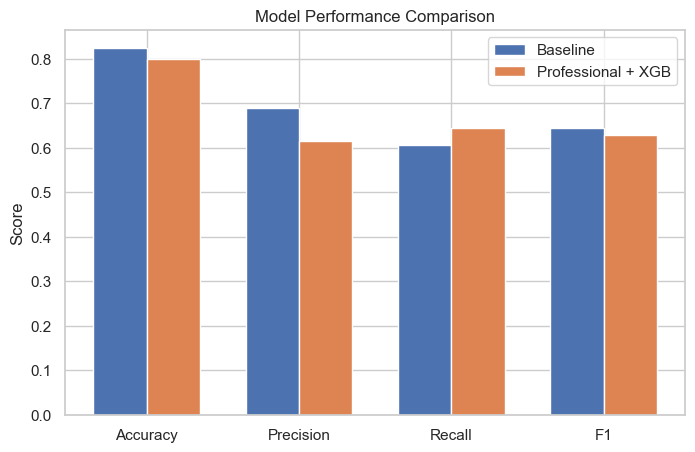

In [15]:
# ============================================================
# COMPARISON PLOT
# ============================================================

metrics = ['Accuracy','Precision','Recall','F1']
baseline_vals = list(baseline_results.values())
professional_vals = list(professional_results.values())

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x-width/2, baseline_vals, width, label='Baseline')
plt.bar(x+width/2, professional_vals, width, label='Professional + XGB')

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.show()


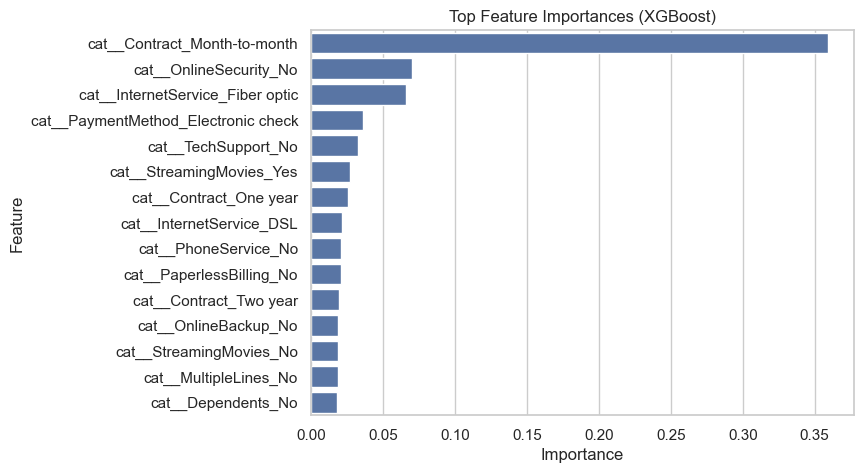

In [16]:
# ============================================================
# FEATURE IMPORTANCE
# WHY: Show what drives churn (Contract, Billing, Charges, etc.)
# ============================================================

feature_names = preprocess.get_feature_names_out()
importances = xgb.feature_importances_

feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_imp = feat_imp.sort_values("Importance", ascending=False).head(15)

plt.figure(figsize=(7,5))
sns.barplot(data=feat_imp, x="Importance", y="Feature")
plt.title("Top Feature Importances (XGBoost)")
plt.show()


              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1036
           1       0.61      0.64      0.63       373

    accuracy                           0.80      1409
   macro avg       0.74      0.75      0.75      1409
weighted avg       0.80      0.80      0.80      1409



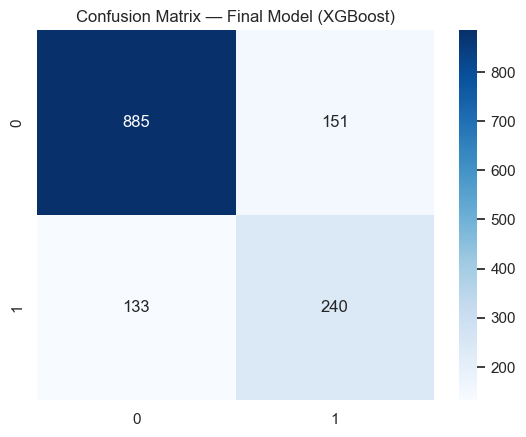

In [17]:
# ============================================================
# CONFUSION MATRIX & CLASSIFICATION REPORT
# ============================================================

print(classification_report(y_test, y_pred_p))

cm = confusion_matrix(y_test, y_pred_p)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix — Final Model (XGBoost)")
plt.show()
